In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Fetch BTC trade raw data
today = datetime.date.today()
BTC_raw = yf.download('BTC-USD', start=today-datetime.timedelta(days=700), end=today)
# BTC_raw.columns = ['date', 'open_price', 'high', 'low', 'close_price', 'adj close', 'volume']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Split the raw data into parts
BTC_basic = BTC_raw[['Adj Close', 'Open']]
BTC_quant = BTC_raw

Text(0, 0.5, 'Prices ($)')

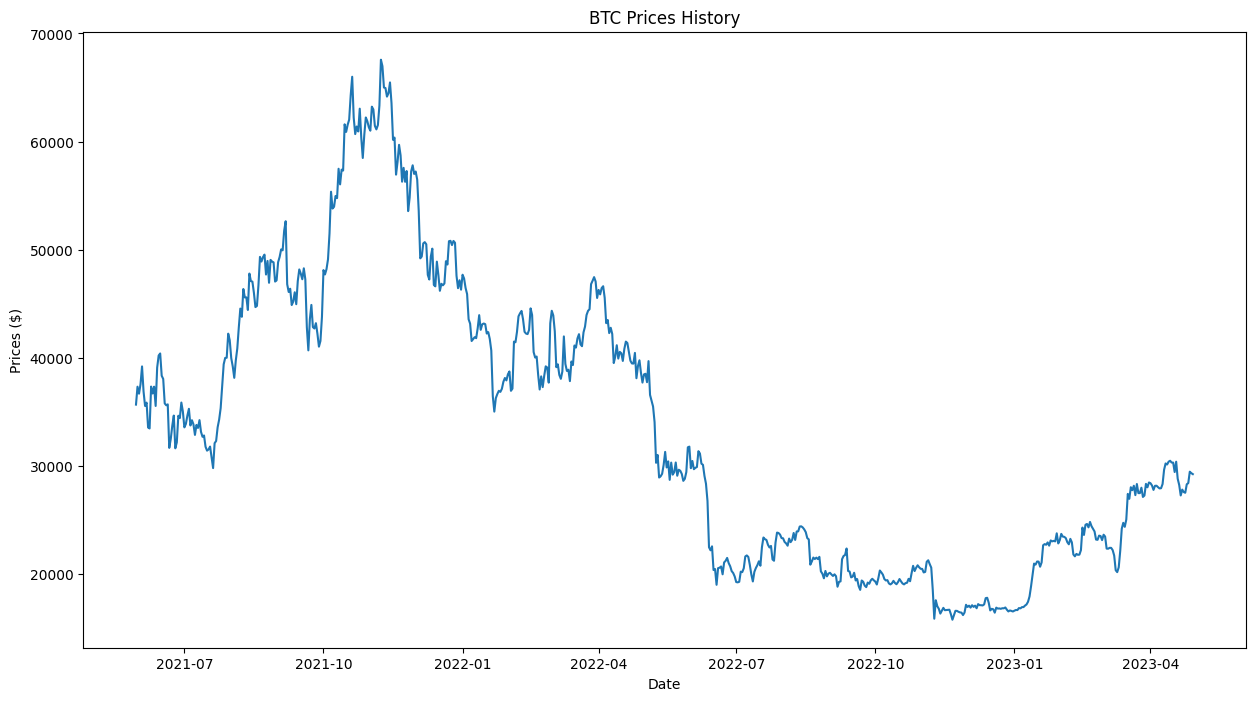

In [5]:
plt.figure(figsize=(15, 8))
plt.title('BTC Prices History')
plt.plot(BTC_quant['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [6]:
### The code below is for merge sentimental data ONLY
### The code contains the merge, split train and test data, and train the model
### The code will be commented until the sentimental data is fetched
def merge_sentimental_data(sentimental_data_file_path, BTC_data):
  # Load sentimental data in csv
  sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
  # sentiment_data = pd.DataFrame(0, index=range(23), columns=sentiment_data.columns)
  zeros = pd.DataFrame([0]*21)
  sentiment_data = pd.concat([zeros, sentiment_data], ignore_index=True)

  # Merge with BTC quant
  merged_data = pd.concat([BTC_data, sentiment_data], axis=1)
  num_rows = len(BTC_data)

  # 创建一个与other_data索引长度相同的全0 DataFrame
  new_data_adjusted = pd.DataFrame([0] * num_rows, index=BTC_data.index)

  # 从底部开始填充sentiment_data的值
  new_data_adjusted.iloc[-len(sentiment_data):] = sentiment_data.values

  # 将new_data_adjusted添加到BTC_quant作为新的一列
  merged_data = pd.concat([BTC_data, new_data_adjusted], axis=1)
  merged_data.columns = list(BTC_data.columns) + ['sentiment']
  return merged_data

In [7]:
### The code below is for merge sentimental data ONLY
### The code contains the merge, split train and test data, and train the model
### The code will be commented until the sentimental data is fetched

sentimental_data_file_path = './vader.csv'
BTC_data = BTC_quant
merged_data = merge_sentimental_data(sentimental_data_file_path, BTC_data)

# Normalise data, if necessary
price_data = merged_data['Adj Close'].values.reshape(-1, 1)
sentiment_data = merged_data['sentiment'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))

scaled_price_data = scaler.fit_transform(price_data)
scaled_sentiment_data = scaler_sentiment.fit_transform(sentiment_data)
# Create window size
def create_dataset(price_dataset, sentiment_dataset, look_back=1, sentiment_weight=0.01):
    x_train, y_train = [], []
    for i in range(len(price_dataset) - look_back - 1):
        x_train.append(np.hstack((price_dataset[i:(i + look_back), 0], sentiment_weight * sentiment_dataset[i:(i + look_back), 0])))
        y_train.append(price_dataset[i + look_back, 0])
    return np.array(x_train), np.array(y_train)


training_data_len = math.ceil(len(scaled_price_data) * 0.8)
training_price_data = scaled_price_data[0: training_data_len, :]
training_sentiment_data = scaled_sentiment_data[0: training_data_len, :]

# Create train set
window_size = 30
x_train, y_train = create_dataset(training_price_data, training_sentiment_data, window_size)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create test set
test_price_data = scaled_price_data[training_data_len - window_size:, :]
test_sentiment_data = scaled_sentiment_data[training_data_len - window_size:, :]

x_test, y_test = create_dataset(test_price_data, test_sentiment_data, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = BTC_quant['Adj Close'].values[training_data_len:]


In [ ]:
"""
# Preparing training set (80%)
x_train = []
y_train = []
# Extract close price
close_price = BTC_quant['Adj Close']
training_data_len = math.ceil(len(close_price.values)* 0.8)
# Normalised data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_price.values.reshape(-1,1))
training_data = scaled_data[0: training_data_len, :]

# Create a price window with 30 days
window_size = 30
for i in range(window_size, len(training_data)):
    x_train.append(training_data[i-window_size:i, 0])
    y_train.append(training_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Preparing testing set (20%)
test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = close_price.values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
"""

"\n# Preparing training set (80%)\nx_train = []\ny_train = []\n# Extract close price\nclose_price = BTC_quant['Adj Close']\ntraining_data_len = math.ceil(len(close_price.values)* 0.8)\n# Normalised data\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled_data = scaler.fit_transform(close_price.values.reshape(-1,1))\ntraining_data = scaled_data[0: training_data_len, :]\n\n# Create a price window with 30 days\nwindow_size = 30\nfor i in range(window_size, len(training_data)):\n    x_train.append(training_data[i-window_size:i, 0])\n    y_train.append(training_data[i, 0])\n    \nx_train, y_train = np.array(x_train), np.array(y_train)\nx_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))\n\n# Preparing testing set (20%)\ntest_data = scaled_data[training_data_len-window_size: , : ]\nx_test = []\ny_test = close_price.values[training_data_len:]\n\nfor i in range(window_size, len(test_data)):\n  x_test.append(test_data[i-window_size:i, 0])\n\nx_test = np.array(x_test)\nx_test

In [ ]:
# Create Model
model = keras.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.3))

model.add(layers.GRU(units=50, return_sequences=True))  # GRU layer
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1))
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_111 (LSTM)             (None, 60, 50)            10400     
                                                                 
 dropout_148 (Dropout)       (None, 60, 50)            0         
                                                                 
 gru_37 (GRU)                (None, 60, 50)            15300     
                                                                 
 dropout_149 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_112 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_150 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_113 (LSTM)             (None, 50)              

In [8]:
### Grid Search Part ###
# The Code is Commented #
"""
from tensorflow.keras import layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer=keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), dropout_rate=0.3, units=30):
    model = keras.Sequential()
    model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.GRU(units=units, return_sequences=True))  # GRU layer
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.LSTM(units=units))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units=1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model
model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'amsgrad'],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'units': [30, 50, 70],
    'batch_size': [8, 16, 32, 64],
    'epochs': [50, 100]
}
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
"""

<ipython-input-8-f00bb3100481>:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
288 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/pyth

Best score: -0.002625 using {'batch_size': 32, 'dropout_rate': 0.0, 'epochs': 100, 'optimizer': 'adam', 'units': 50}


In [ ]:
### Traning ###
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=100)
model.save(f'./LSTM_model.h5')

Epoch 1/100
17/17 [==============================] - 9s 17ms/step - loss: 0.1407
Epoch 2/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0744
Epoch 3/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0390
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0102
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0116
Epoch 6/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0125
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0107
Epoch 8/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0094
Epoch 9/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0054
Epoch 10/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0053
Epoch 11/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0057
Epoch 12/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0081
Epoch 13/100
17/17 [=====

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 1s 8ms/step


413.25847993480215

<ipython-input-30-590061e52ab2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


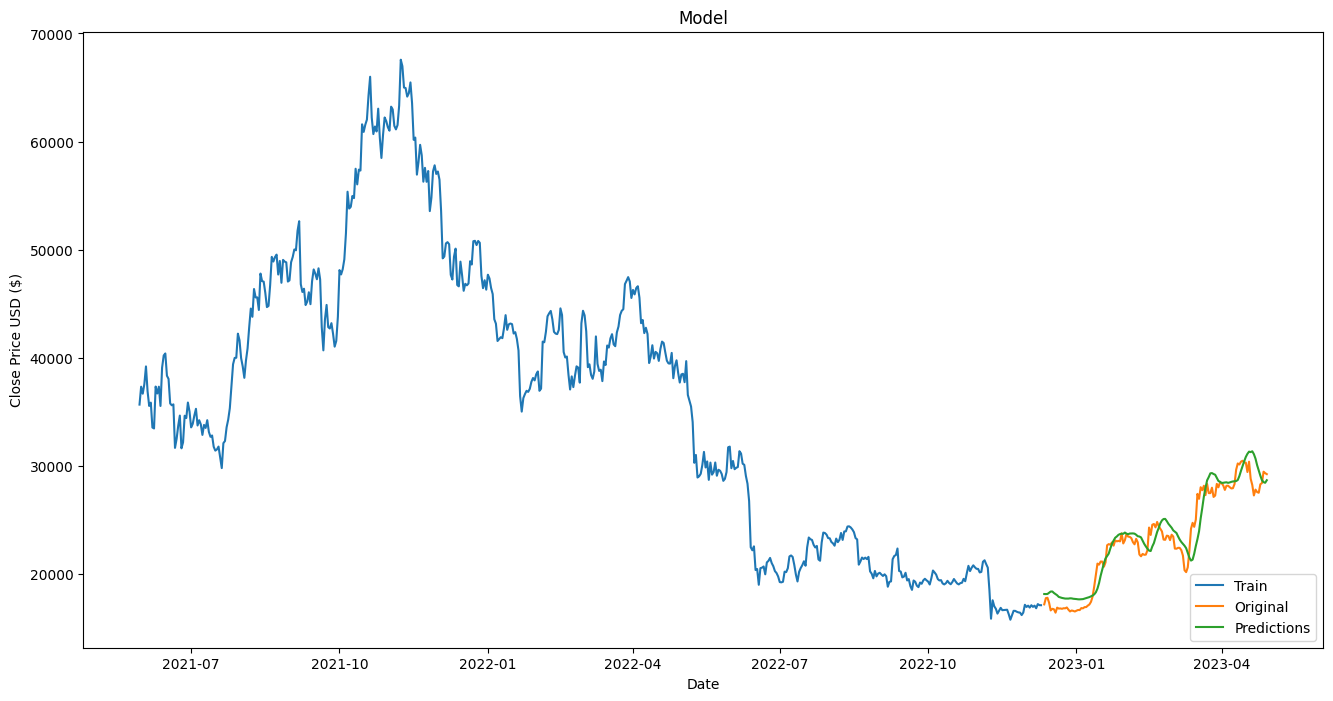

In [ ]:
data = BTC_quant.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len+1:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Original', 'Predictions'], loc='lower right')
plt.savefig('./LSTM_Result.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
file_path='./BTC_prediction.csv'
validation.to_csv(file_path, index=False)

In [ ]:
error = validation.iloc[-1, 0] - validation.iloc[-1, 1]

In [ ]:
validation.iloc[-1, 0] - validation.iloc[-1, 1]

563.111328125

In [ ]:
"""
def predict_and_plot_btc_prices(num_days_to_predict, sentimental_data_file_path):
  today = datetime.date.today()
  stock_quote = yf.download('BTC-USD', start=today-datetime.timedelta(days=365), end=today)
  new_df=stock_quote.filter(['Adj Close'])
  merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)
  last_30_days = merged_data[-30:].values
  last_30_days_scaled = scaler.transform(last_30_days)
  predictions = []
  predicted_dates = []
  error = validation.iloc[-1, 0] - validation.iloc[-1, 1]
  for _ in range(num_days_to_predict):
    offset = error*(-0.03*_)
    if (offset<0):
      offset = 0
    last_date = merged_data.index[-1]
    # Create an empty list for the current iteration
    X_test = []
    # Append the past 30 days of scaled data
    X_test.append(last_30_days_scaled)
    # Convert the X_test data into a numpy array
    X_test = np.array(X_test)
    # Reshape the data
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Get the predicted scaled price
    pred_price = model.predict(X_test)
    # Undo the scaling
    pred_price_unscaled = scaler.inverse_transform(pred_price)
    # Add the unscaled predicted price to the list of predictions
    predictions.append(pred_price_unscaled[0][0]+offset)
    # Update last_30_days_scaled by removing the first day and adding the predicted price
    last_30_days_scaled = np.concatenate((last_30_days_scaled[1:], pred_price), axis=0)
    # Add the predicted date to the list of predicted_dates
    predicted_date = last_date + datetime.timedelta(days=_+1)
    predicted_dates.append(predicted_date)
  print(f"Price of BTC-USD for the next {num_days_to_predict} trading days: {predictions}")
  fig, ax = plt.subplots()
  ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
  ax.set(xlabel='Date', ylabel='BTC-USD Price', title=f'Predicted BTC-USD Prices for the Next {num_days_to_predict} Trading Days')
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
  ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=5))
  plt.xticks(rotation=45)
  plt.legend()
  plt.grid()
  plt.savefig(f'./Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
  plt.show()
"""

'\ndef predict_and_plot_btc_prices(num_days_to_predict, sentimental_data_file_path):\n  today = datetime.date.today()\n  stock_quote = yf.download(\'BTC-USD\', start=today-datetime.timedelta(days=365), end=today)\n  new_df=stock_quote.filter([\'Adj Close\'])\n  merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)\n  last_30_days = merged_data[-30:].values\n  last_30_days_scaled = scaler.transform(last_30_days)\n  predictions = []\n  predicted_dates = []\n  error = validation.iloc[-1, 0] - validation.iloc[-1, 1]\n  for _ in range(num_days_to_predict):\n    offset = error*(-0.03*_)\n    if (offset<0):\n      offset = 0\n    last_date = merged_data.index[-1]\n    # Create an empty list for the current iteration\n    X_test = []\n    # Append the past 30 days of scaled data\n    X_test.append(last_30_days_scaled)\n    # Convert the X_test data into a numpy array\n    X_test = np.array(X_test)\n    # Reshape the data\n    X_test = np.reshape(X_test, (X_test.shape[0], X_t

In [ ]:
### The code below is for dataset that merge sentimental data ONLY
### The code will be commented until the sentimental data is fetched
file_path='./prediction.csv'
validation.to_csv(file_path, index=False)
error = validation.iloc[-1, 0] - validation.iloc[-1, 1]
def predict_and_plot_btc_prices(num_days_to_predict, sentimental_data_file_path):
    ### Fetch BTC-USD data BEGIN ###
    ### CHANGE THIS TO THE FUNCTION USING PYSPARK ###
    today = datetime.date.today()
    BTC_quant = yf.download('BTC-USD', start=today-datetime.timedelta(days=365), end=today)
    ### Fetch BTC-USD data END ###
    new_df=BTC_quant.filter(['Adj Close'])
    # Merge sentimental data
    merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)
    # Create 30 window days slot
    last_30_days = merged_data[-30:].values
    last_30_days_price = merged_data['Adj Close'][-30:].values.reshape(-1, 1)
    last_30_days_sentiment = merged_data['sentiment'][-30:].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    last_30_days_scaled_price = scaler.fit_transform(last_30_days_price)
    sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
    sentiment_values = sentiment_data.values.reshape(-1, 1)
    scaler_sentiment = MinMaxScaler()
    scaled_sentiment = scaler_sentiment.fit_transform(sentiment_values)
    last_30_days_scaled_sentiment = scaler_sentiment.transform(last_30_days_sentiment)
    predictions = []
    predicted_dates = []
    # Predict price
    for _ in range(num_days_to_predict):
        offset = error*(0.5-0.03*_)
        if (offset<0):
          offset = 0
        last_date = merged_data.index[-1]
        X_test = []
        X_test.append(np.hstack((last_30_days_scaled_price.flatten(), last_30_days_scaled_sentiment.flatten())))
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        pred_price_unscaled = scaler.inverse_transform(pred_price)
        predictions.append(pred_price_unscaled[0][0]+offset)
        last_30_days_scaled_price = np.concatenate((last_30_days_scaled_price[1:], pred_price), axis=0)
        predicted_date = last_date + datetime.timedelta(days=_+1)
        predicted_dates.append(predicted_date)
    # print(f"Price of BTC-USD for the next {num_days_to_predict} trading days: {predictions}")
    output_text = f"Price of BTC-USD for the next {num_days_to_predict} trading days: {predictions}"
    print(output_text)
    # file_name = f"./public/BTC/Prediction_{num_days_to_predict}days.txt"
    # with open(file_name, 'w') as file:
      # file.write(output_text)
    fig, ax = plt.subplots()
    ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
    ax.set(xlabel='Date', ylabel='BTC-USD Price', title=f'Predicted BTC-USD Prices for the Next {num_days_to_predict} Trading Days')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=num_days_to_predict+3))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    # plt.savefig(f'/src/Components/BTC/Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
    plt.show()

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
Price of BTC-USD for the next 1 trading days: [29104.0439453125]


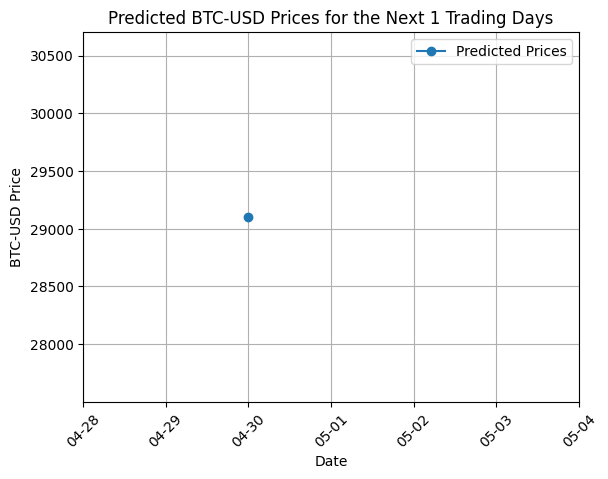

In [ ]:
sentimental_data_file_path = './vader.csv'
predict_and_plot_btc_prices(1, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
Price of BTC-USD for the next 3 trading days: [29104.0439453125, 28979.35568359375, 28908.862734375]


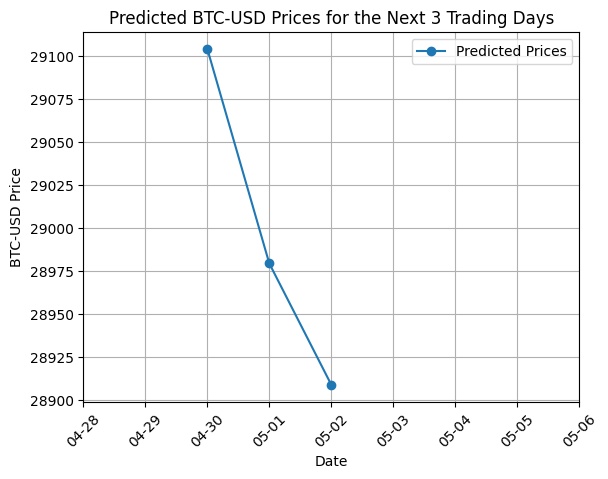

In [ ]:
predict_and_plot_btc_prices(3, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 20ms/step
Price of BTC-USD for the next 5 trading days: [29104.0439453125, 28979.35568359375, 28908.862734375, 28890.27408203125, 28923.9901171875]


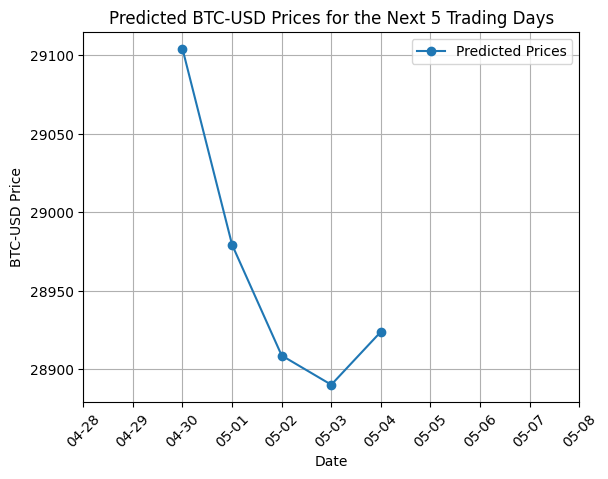

In [ ]:
predict_and_plot_btc_prices(5, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 25ms/step
Price of BTC-USD for the next 30 trading days: [29104.0439453125, 28979.35568359375, 28908.862734375, 28890.27408203125, 28923.9901171875, 28998.58505859375, 29108.408515625, 29244.39798828125, 29395.9011328125, 29555.75388671875, 29720.364453125, 29884.43205078125, 30036.8629296875, 30160.01646484375, 30242.41609375, 30293.79814453125, 30331.1684765625, 30362.837890625, 30393.099609375, 30408.41015625, 30414.759765625, 30415.927734375, 30415.34375, 30414.673828125, 30414.2421875, 30413.849609375, 30413.19921875, 30412.001953125, 30410.068359375, 30407.740234375]


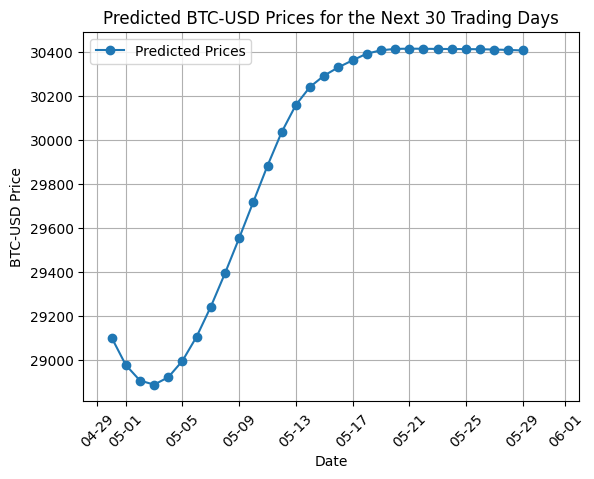

In [ ]:
predict_and_plot_btc_prices(30, sentimental_data_file_path)